In [8]:
from tqdm import trange, tqdm
from collections import defaultdict
import numpy as np
from itertools import product
from scipy.special import gamma
from scipy.spatial.distance import pdist, squareform, euclidean
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from random import randint
from sklearn.linear_model import LinearRegression
import math
from functions_for_clustering import *

In [5]:
PTS = 40
WINDOW = 30
STEPS = 5

## ДОБАВИТЬ БОЛЬШЕ МОТИВОФ!!!!! 

In [1]:
def parse(pattern, pattern_motifs):
    f = open('motifs/thamotifs%s.txt' % ''.join(map(str, pattern)), 'r')
    f.readline()
    temp_arr = []
    for line in f:
        line = list(map(float, line.split(", ")))
        temp = []
        for x in pattern:
            temp.append(line[x])
        temp_arr.append(temp)
    
    pattern_motifs[str_subseq(pattern + (WINDOW - 1,))] = temp_arr
    f.close()
    return pattern_motifs

In [18]:
centers = dict()
parse((0, 1, 2, 4, 14), centers)
parse((0, 4, 7, 9, 14), centers)
parse((0, 5, 6, 8, 10), centers)
parse((0, 5, 6, 8, 10), centers)
parse((0, 6, 7, 9, 12), centers)
parse((0, 1, 7, 12, 14), centers)
parse((0, 5, 7, 10, 12), centers)
parse((0, 5, 8, 10, 14), centers)
parse((0, 6, 7, 10, 11), centers)
parse((0, 4, 10, 11, 14), centers)
parse((6, 9, 12, 13, 14), centers)

{'0,1,2,4,14,29': [[0.003449562274149443,
   -0.00015833726200786062,
   -0.0008210815144601959,
   -0.00044733046804511413,
   0.0020994774303935266],
  [0.009252342801046674,
   0.00521011062817418,
   -0.0078640955215852,
   -0.011321990354968652,
   -0.04125097719879936],
  [0.01734682258474024,
   0.010190539916182722,
   0.0018310684140157847,
   -0.00955583833639294,
   0.007716626070127018],
  [-6.715265281287689e-24,
   -1.5175626060057436e-23,
   -3.0401648829857555e-23,
   -8.45436421442802e-24,
   -9.339135948179345e-24],
  [0.01591479692338991,
   0.005328672285562303,
   -0.0061821821997053526,
   0.005676118439229171,
   0.013499948610440576],
  [0.06710513539854415,
   -0.01811613823934322,
   -0.015931860197284348,
   -0.012754824182758506,
   0.010370774102355733],
  [0.004210154457973394,
   0.003746126865680772,
   0.004147457601930029,
   -0.0034779367933099785,
   -0.0013708539860536055],
  [-0.01215215508959483,
   -0.0022007719981818313,
   0.006581131291115144,

In [7]:
def aggr_d(pts):
    # weighted sum by distance
    if not pts:
        return None
    sum_weight = sum(map(lambda center: center[1], pts))
    pred = sum(map(lambda center: center[0] * center[1], pts))
    return pred / sum_weight

def aggr_q(pts):
    # weighted sum by q-value
    if not pts:
        return None
    sum_weight = sum(map(lambda center: center[2], pts))
    pred = sum(map(lambda center: center[0] * center[2], pts))
    return pred / sum_weight

def krutoi_prediction(mode, start_point, step, center):
    if mode == "dist":
        pred = aggr_d(center)
    elif mode == "q-val":
        pred = aggr_q(center)
    return pred

In [9]:
def str_subseq(subseq):
    if not subseq:
        return '<None>'
    return ','.join(map(str, subseq))


def gen_sample_in_point_with_q(values, window, pattern, pos):
    # наложить шаблон 
    if pos - window + 1 + pattern[0] >= 0:
        vals = []
        bad = values[pos][0] == None
        for j in pattern:
            val = values[pos - window + 1 + j]
            if val[0] == None:
                bad = True
                break
            vals.append(val)
        if bad:
            return None
        vals.append(values[pos])
        return vals
    else:
        return None

In [71]:
def generate_predictions(centers, return_set_pred=False, real_mode='test', EPS=0.05, Q_VALUE=0.96):
    #centers - словарь, какой ключ и значение хуй их пойми (судя по всему паттерн - ряд загенеренный по этому паттерну)
    #patterns - лист таплов паттернов 
    #xs - наш ряд по которому мы предсказываем
    
    preds = {}
    set_preds = {}

    if real_mode == 'test':
        end_point = 130 #val_end 
        init_point = 100 #test_init
    else:
        end_point = train_end
        init_point = val_init

    for start_point in tqdm(range(PTS)):
        
        # initialize empty
        preds[start_point] = [None] * (start_point + 1)
        if return_set_pred:
            set_preds[start_point] = [None] * (start_point + 1)

        # current window
        wind = list(map(lambda x: (x, 1), xs[init_point + start_point : end_point + start_point]))

        for step in range(1, STEPS + 1):
            x_tests_for_point = {}
            for pattern in patterns:
                
                key = str_subseq(pattern + (WINDOW - 1,))
                sample = gen_sample_in_point_with_q(np.concatenate([wind, [(0, 0)]]), WINDOW, pattern, len(wind))
                if not sample:
                    x_tests_for_point[key] = None
                else:
                    x_tests_for_point[key] = sample

            chosen_centers = []
            for pattern, centers_values in centers.items():
                if not x_tests_for_point[pattern]:
                    continue
                vector = np.array(x_tests_for_point[pattern][:-1])[:, 0]
                q_values = np.array(x_tests_for_point[pattern][:-1])[:, 1]

                for center in centers_values:
                    dist = euclidean(vector[:-1], center[:-1])
                    if dist < EPS:
                        weight_d = (EPS - dist) / EPS
                        weight_q = np.mean(q_values) * Q_VALUE
                        chosen_centers.append((pattern, center, weight_d, weight_q))

            last_points = list(map(lambda center: (center[1][-1], center[2], center[3], center[0]), chosen_centers))
            
            # deamon predict
            result_point = krutoi_prediction("q-val", start_point, step, last_points)
            preds[start_point].append(result_point)

            if return_set_pred:
                set_preds[start_point].append(last_points)

            
            if result_point:
                q_value = np.mean(np.array(list(map(lambda center: center[2], chosen_centers))))
            else:
                q_value = None
            
            # move the window
            wind = np.concatenate([wind[1:], [(result_point, q_value)]])

#     deamon.predicted = True

    if return_set_pred:
        return preds, set_preds
    return preds

236
[(0, 1, 2, 4, 14), (0, 4, 7, 9, 14), (0, 5, 6, 8, 10), (0, 6, 7, 9, 12), (0, 1, 7, 12, 14), (0, 5, 7, 10, 12), (0, 5, 8, 10, 14), (0, 6, 7, 10, 11), (0, 4, 10, 11, 14), (6, 9, 12, 13, 14)]


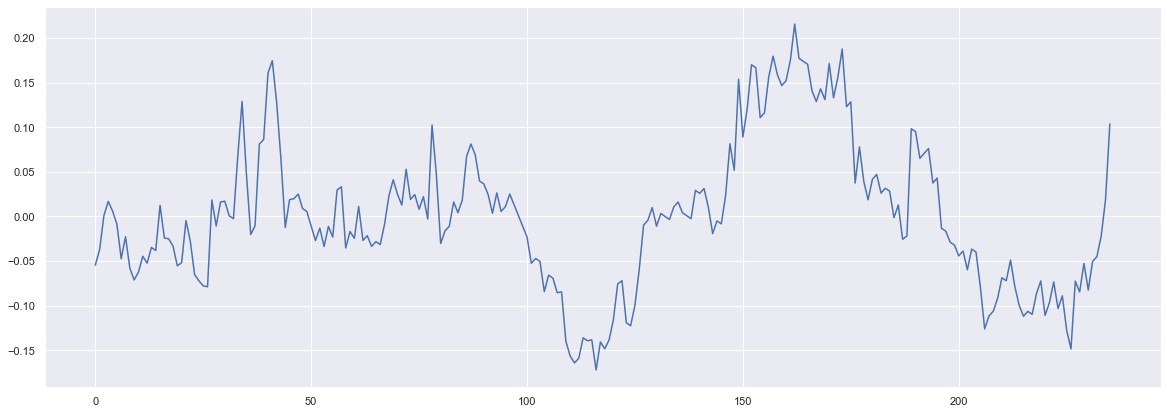

In [60]:
df = pd.read_csv('data/test/part_5.csv')
df_pred = df.loc[df.index == 100]
df_pred = df_pred.drop(labels=['Ticker', 'index', 'Date', 'extremum'], axis=1)
df_pred = df_pred.dropna(axis=1)

xs_temp = df_pred.values.tolist()
xs = detrend(xs_temp)
xs = list(np.array(xs).flatten())
xs = xs[::-1]
sns.lineplot(y=xs, x=list(range(len(xs))))
print(len(xs))
patterns = []
for x in centers.keys():
    temp = tuple(map(int, x.split(",")))
    patterns.append(temp[:-1])
print(patterns)

# BEHOLD THE MIGHTY PREDICTION 

In [74]:
predicted_points = generate_predictions(centers)
predicted_points

100%|██████████| 40/40 [00:09<00:00,  4.29it/s]


{0: [None, 0.3167791105999247, None, None, None, None],
 1: [None, None, None, None, None, None, None],
 2: [None, None, None, None, None, None, None, None],
 3: [None, None, None, None, None, None, None, None, None],
 4: [None, None, None, None, None, None, None, None, None, None],
 5: [None, None, None, None, None, None, None, None, None, None, None],
 6: [None, None, None, None, None, None, None, None, None, None, None, None],
 7: [None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None],
 8: [None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None],
 9: [None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None],
 10: [None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None],
 11: [None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
 

[0.3167791105999247]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.012583577006093223]
[0.012583577006093223, 0.0037673337786814746]
[0.012583577006093223, 0.0037673337786814746, 0.0013106797634883064]
[0.012583577006093223, 0.0037673337786814746, 0.0013106797634883064, 0.0017376396882615634]
[0.012583577006093223, 0.0037673337786814746, 0.0013106797634883064, 0.0017376396882615634, 0.001959980475197307]
[0.0037673337786814746, 0.0013106797634883064, 0.0017376396882615634, 0.001959980475197307, -0.00025239934661679]
[0.0013106797634883064, 0.0017376396882615634, 0.001959980475197307, -0.00025239934661679, -0.0028644555878306133]
[0.0017376396882615634, 0.001959980475197307, -0.00025239934661679, -0.0028644555878306133, -0.0006841267574973935]
[0.001959980475197307, -0.00025239934661679, -0.0028644555878306133, -0.0006841267574973935, -0.0008286835930198656]
[-0.00025239934661679, -0.0028644555878306133, -0.0006841267574973935, -0.0008286835930198656, -0.0007934701036783279]
[-0.00286445

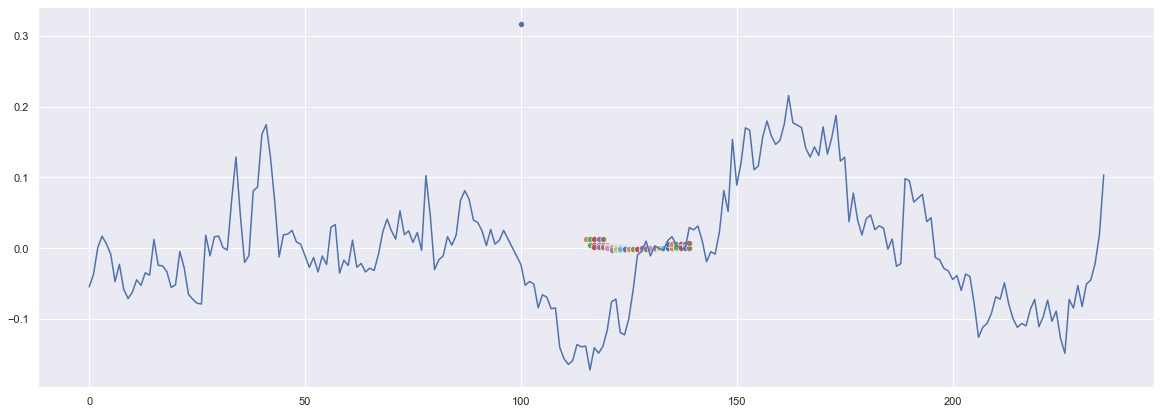

In [73]:
sns.set(rc={'figure.figsize':(20,7)})
sns.lineplot(y=xs, x=list(range(len(xs))))

for x in predicted_points.items():
    start_point, predicted_values = x[0], x[1]
    predicted_values = list(filter(None, predicted_values))
    print(predicted_values)
    sns.scatterplot(y=predicted_values, x=start_point + 100)